In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.stats.mstats import winsorize
from random import seed
from random import random
import seaborn as sns

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

## load data

In [2]:
def load_data(load):
    spot = pd.read_csv(f'data/spot_{load}_usdt_1h.csv', parse_dates=['timestamp'])
    perp = pd.read_csv(f'data/perp_{load}_usdt_1h.csv', parse_dates=['timestamp'])

    perp.sort_values(by = 'epoch', ascending=True, inplace=True)
    spot.sort_values(by = 'epoch', ascending=True, inplace=True)
    perp = perp.reset_index(drop=True)
    spot = spot.reset_index(drop=True)
    
    funding_rate = pd.read_csv(f'data/rate_{load}_usdt.csv', parse_dates=['timestamp'])
    
    return spot, perp, funding_rate
    

In [3]:
def brownian_motion(N, T, h):
    """
    Simulates a Brownian motion
    :param int N : the number of discrete steps
    :param int T: the number of continuous time steps
    :param float h: the variance of the increments
    """
    dt = 1.0 * T/N  # the normalizing constant; total number of steps
    random_increments = np.random.normal(0.0, 1.0 * h, N)*np.sqrt(dt)  # the epsilon values
    brownian_motion = np.cumsum(random_increments)  # calculate the brownian motion
    brownian_motion = np.insert(brownian_motion, 0, 0.0) # insert the initial condition

    return brownian_motion, random_increments

def drifted_brownian_motion(mu, sigma, N, T):
    """Simulates a Brownian Motion with drift.
    
    :param float mu: drift coefficient
    :param float sigma: volatility coefficient
    :param int N : number of discrete steps
    :param int T: number of continuous time steps
    :param int seed: initial seed of the random generator
    :returns list: drifted Brownian motion
    """
    # standard brownian motion
    W, _ = brownian_motion(N, T , 1.0)
    # the normalizing constant
    dt = 1.0 * T/N
    # generate the time steps
    time_steps = np.linspace(0.0, N*dt, N+1)
    # calculate the Brownian Motion with drift
    X = mu * time_steps + sigma * W
    return X

In [4]:
def create_panel(spot, perp, funding_rate):
    
    #create the panel
    panel = perp[['epoch', 'timestamp', 'close', 'usd_volume']]
    panel['day'] = panel['timestamp'].dt.round('D')
    panel = panel.rename(columns={'close': 'perp', 'usd_volume': 'perp_usd_volume'})

    panel = pd.merge(panel,
                     spot[['epoch', 'close', 'usd_volume']],
                     on='epoch', 
                     how='left')
    panel = panel.rename(columns={'close': 'spot', 'usd_volume': 'spot_usd_volume'})
    
    panel = pd.merge(panel,
                     funding_rate[['epoch', 'funding_rate']],
                     on='epoch', 
                     how='left')

    panel = pd.merge(panel,
                     i_crypto[['epoch', 'apy']],
                     on='epoch', 
                     how='right')
    panel = panel.rename(columns={'apy': 'icrypto'})

    panel = pd.merge(panel,
                     i_usdt[['epoch', 'apy']],
                     on='epoch', 
                     how='right')
    panel = panel.rename(columns={'apy': 'iusdt'})

    panel.sort_values(by = 'epoch', ascending=True, inplace=True)
    panel = panel.reset_index(drop=True)

    return panel

In [71]:
currencies = ['eth', 'btc', 'doge', 'bnb', 'ada']
panel_all = []

spot, perp, funding_rate = load_data(currencies[0])
np.random.seed(40)

#load and process the usd interest rate
i_usdt = pd.read_csv(f'data/usd_interest_combined.csv',  usecols=['date', 'mean'], parse_dates=['date'])
i_usdt = i_usdt.rename(columns={'date': 'timestamp', 'mean': 'apy'})
fill_beginning = i_usdt.iloc[:30].mean()

i_usdt = pd.merge(perp.copy()[['epoch', 'timestamp']],
                 i_usdt, 
                 on='timestamp',
                 how='left')

i_usdt.fillna(method='ffill', inplace=True) #fill every hour with the daily interest rate

#fill the first days with the earliest 30 day average
i_usdt.fillna(value=fill_beginning, inplace=True)

for i in range (0,len(currencies)):
    spot, perp, funding_rate = load_data(currencies[i])
    
    #currently we are simulating the interest rate for crypto
    i_crypto = perp.copy()
    i_crypto = i_crypto[['epoch', 'timestamp']]
    mu = 0.01
    sigma = 0.005
    X = drifted_brownian_motion(-0.005, sigma, len(i_crypto)-1, 1)
    i_crypto['apy'] = X+mu
    
    panel_temp = create_panel(spot, perp, funding_rate)
    panel_all.append(panel_temp)
    print(f'{currencies[i]} loaded')

eth loaded
btc loaded
doge loaded
bnb loaded
ada loaded


## cleaning

In [76]:
cutoff = '2022-08-30 08:00:00'

eth_start = '2019-11-27 07:00:00'
btc_start = '2019-09-10 08:00:00'
doge_start = '2020-07-10 09:00:00'
bnb_start = '2020-02-10 08:00:00'
ada_start = '2020-01-31 08:00:00'

for i in range (0,len(currencies)):
    panel_all[i] = panel_all[i][panel_all[i]['timestamp'] <= cutoff] #cutoff, such that all data is equally long

In [77]:
#check for dataset and na values
for i in range (0,len(currencies)):
    panel_all[i].info()
    #panel_all[i][panel_all[i]['spot'].isnull()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24200 entries, 0 to 24199
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   epoch            24200 non-null  int64         
 1   timestamp        24200 non-null  datetime64[ns]
 2   perp             24200 non-null  float64       
 3   perp_usd_volume  24200 non-null  float64       
 4   day              24200 non-null  datetime64[ns]
 5   spot             24169 non-null  float64       
 6   spot_usd_volume  24169 non-null  float64       
 7   funding_rate     3052 non-null   float64       
 8   icrypto          24200 non-null  float64       
 9   iusdt            24200 non-null  float64       
dtypes: datetime64[ns](2), float64(7), int64(1)
memory usage: 2.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24200 entries, 0 to 24199
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --

In [78]:
#fill or drop na
for i in range (0,len(currencies)):

    panel_all[i]['spot'] = panel_all[i]['spot'].fillna(method='ffill')
    panel_all[i]['spot_usd_volume'] = panel_all[i]['spot_usd_volume'].fillna(method='ffill')
    #panel_all[i]['funding_rate'] = panel_all[i]['funding_rate'].fillna(0)
    #panel_all[i] = panel_all[i].dropna()
    panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)
    panel_all[i] = panel_all[i].reset_index(drop=True)

## data calculation

In [82]:
for i in range (0,len(currencies)):
    T = 1/(3*365) #we receive interest every 8h for 365 days

    # cip = yt - pt
    panel_all[i]['yt'] = panel_all[i]['iusdt'] - panel_all[i]['icrypto']
    panel_all[i]['pt'] = -(1/T)*(np.log(panel_all[i]['perp']) - np.log(panel_all[i]['spot'])) 


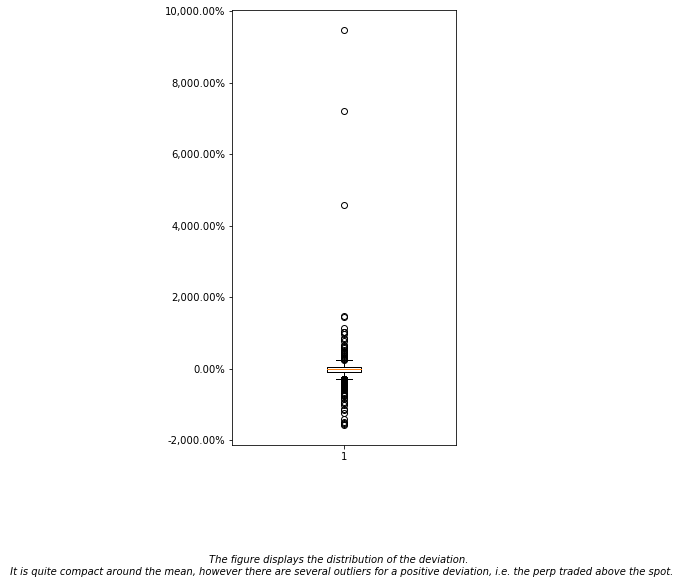

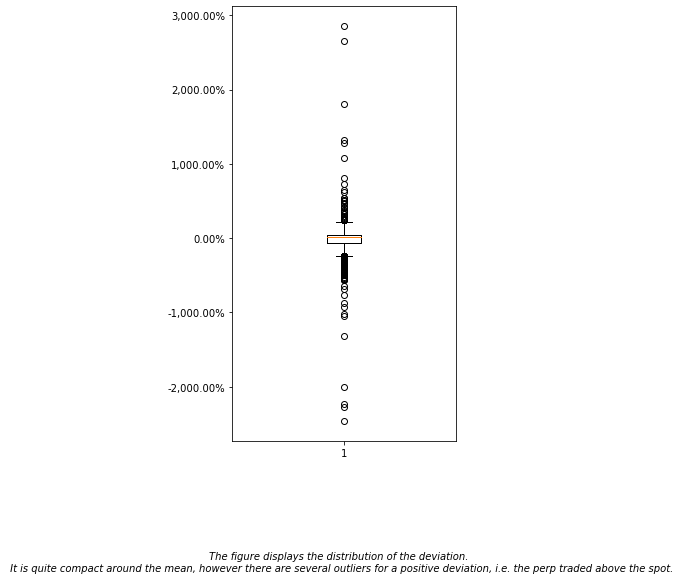

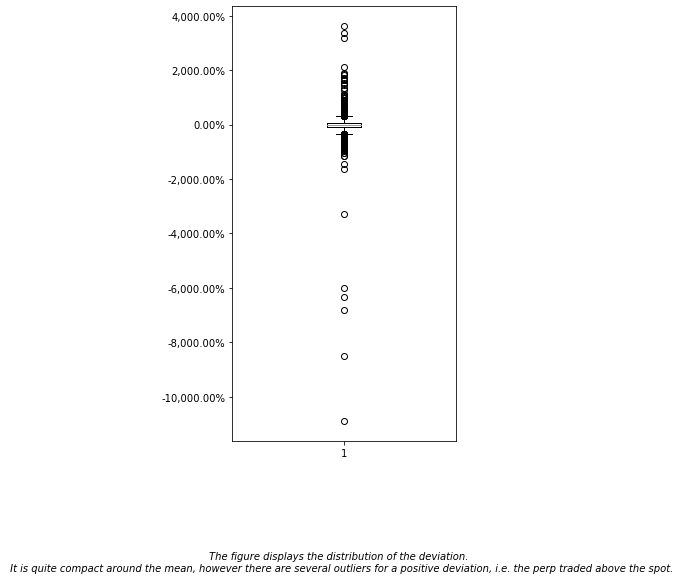

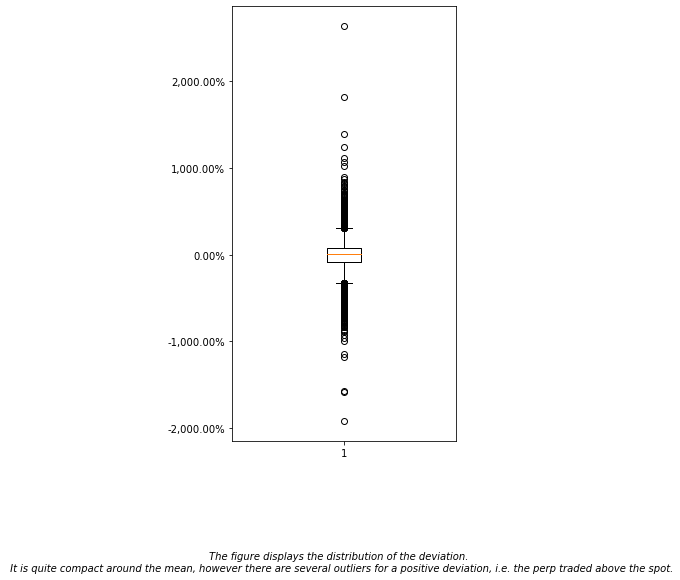

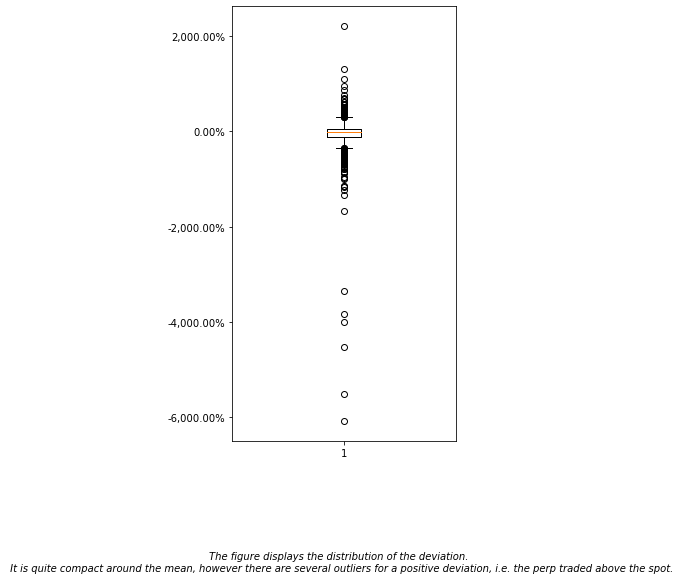

In [83]:
for i in range (0,len(currencies)):
    #take a look at the distribution before winsorization
    
    fig, ax = plt.subplots(figsize =(4,8))
    ax.boxplot(panel_all[i]['pt'])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    txt = f'The figure displays the distribution of the deviation. \n It is quite compact around the mean, however there are several outliers for a positive deviation, i.e. the perp traded above the spot.'
    fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

    plt.show()

In [84]:
#we winsorize at +- 2 standard deviations, to address extrem outliers
for i in range (0,len(currencies)):
    panel_all[i]['yt'] = winsorize(panel_all[i]['yt'], limits=(0.025, 0.025))
    panel_all[i]['pt'] = winsorize(panel_all[i]['pt'], limits=(0.025, 0.025))

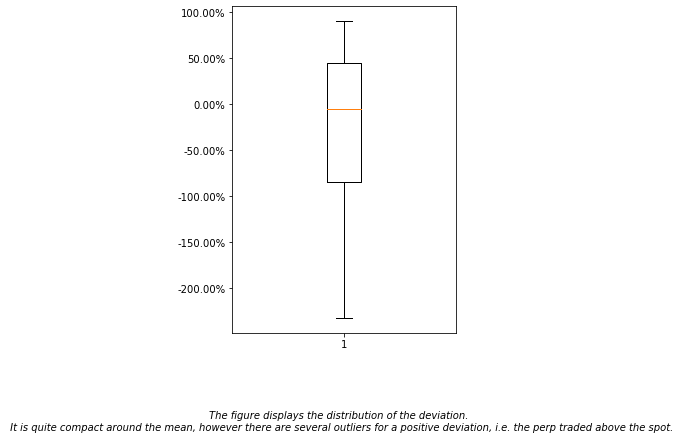

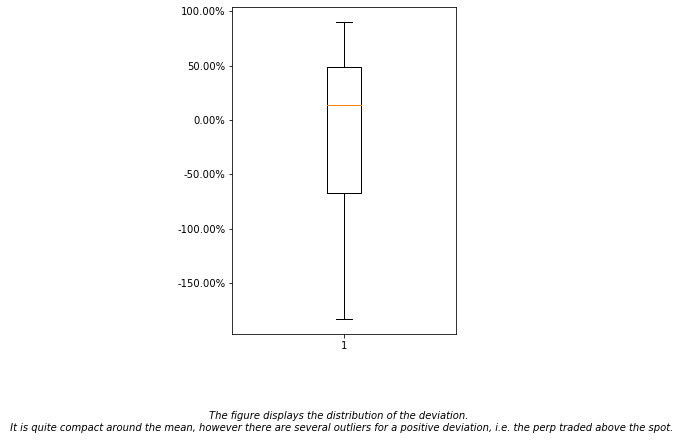

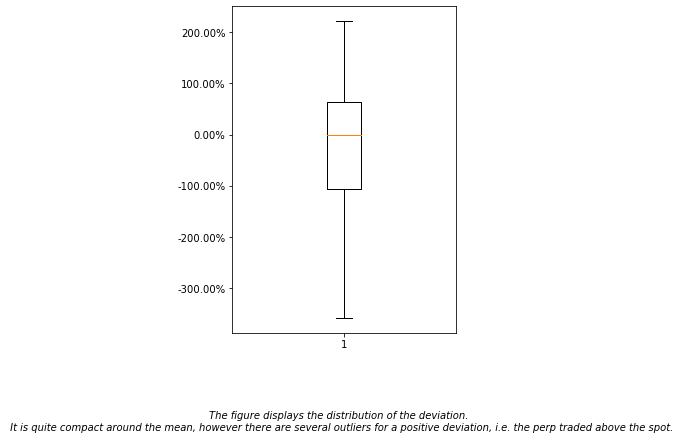

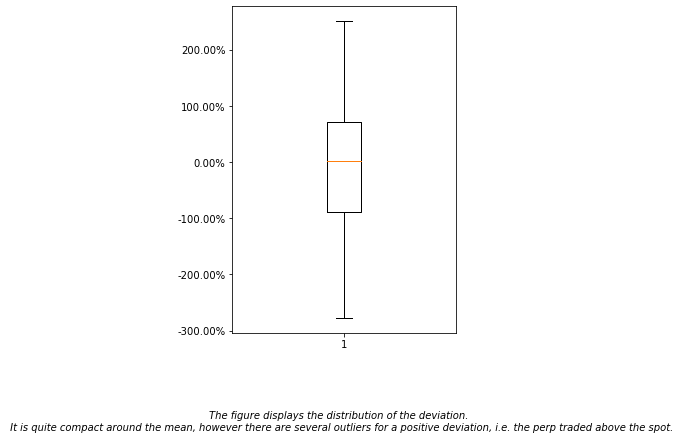

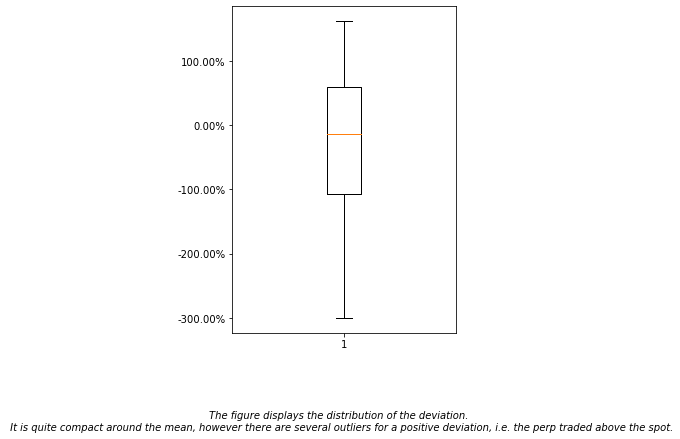

In [85]:
for i in range (0,len(currencies)):
    #take a look at the distribution after winsorization
    
    fig, ax = plt.subplots(figsize =(4,6))
    ax.boxplot(panel_all[i]['pt'])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    txt = f'The figure displays the distribution of the deviation. \n It is quite compact around the mean, however there are several outliers for a positive deviation, i.e. the perp traded above the spot.'
    fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

    plt.show()

In [86]:
for i in range (0,len(currencies)):
    panel_all[i]['cip'] = panel_all[i]['yt'] + panel_all[i]['pt']
    
    #taking the absolute mean
    mean = np.round(panel_all[i]['cip'].mean(),4)

    days = (panel_all[i]['day'].iloc[-1] - panel_all[i]['day'].iloc[0]).days

    print(f'{currencies[i]}: The mean deviation from the covered interest rate parity is {mean*100}%. Sampled from Binance over {days} days.')

eth: The mean deviation from the covered interest rate parity is -21.57%. Sampled from Binance over 1007 days.
btc: The mean deviation from the covered interest rate parity is -7.180000000000001%. Sampled from Binance over 1007 days.
doge: The mean deviation from the covered interest rate parity is -23.189999999999998%. Sampled from Binance over 781 days.
bnb: The mean deviation from the covered interest rate parity is -5.050000000000001%. Sampled from Binance over 932 days.
ada: The mean deviation from the covered interest rate parity is -25.94%. Sampled from Binance over 942 days.


## calculate statistics

In [87]:
#we calculate the statistics mean, std for each year
cip_all = []
cip_all_std = []
cip_all_std_ann = []
yt_all = []
yt_all_std = []
pt_all = []
pt_all_std = []
spot_volume = []
perp_volume = []

for i in range(0, len(currencies)):
    cip_temp = []
    cip_temp_std = []
    cip_temp_std_ann = []
    yt_temp = []
    yt_temp_std = []
    pt_temp = []
    pt_temp_std = []
    spot_volume_temp = []
    perp_volume_temp = []
    
    if panel_all[i]['timestamp'].dt.year.iloc[0] != 2019: #if timeseries starts after 2019
        cip_temp.append(0)
        cip_temp_std.append(0)
        cip_temp_std_ann.append(0)
        yt_temp.append(0)
        yt_temp_std.append(0)
        pt_temp.append(0)
        pt_temp_std.append(0)
        spot_volume_temp.append(0)
        perp_volume_temp.append(0)

    
    for j in range(panel_all[i]['timestamp'].dt.year.iloc[0], panel_all[i]['timestamp'].dt.year.iloc[-1]+1):     
        
        cip_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['cip'].mean())

        cip_temp_std.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['cip'].std())
        
        cip_temp_std_ann.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['cip'].std()*np.sqrt(len(panel_all[i][panel_all[i]['timestamp'].dt.year == j])))
        
        yt_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['yt'].mean())

        yt_temp_std.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['yt'].std())
        
        pt_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['pt'].mean())

        pt_temp_std.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['pt'].std())
        
        spot_volume_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['spot_usd_volume'].sum())
        perp_volume_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['perp_usd_volume'].sum())


    cip_temp.append(panel_all[i]['cip'].mean())
    cip_all.append(cip_temp)
    
    cip_temp_std.append(panel_all[i]['cip'].std())
    cip_all_std.append(cip_temp_std)
    
    cip_temp_std_ann.append(panel_all[i]['cip'].std()*np.sqrt(len(panel_all[i]['timestamp'])))
    cip_all_std_ann.append(cip_temp_std_ann)
    
    yt_temp.append(panel_all[i]['yt'].mean())
    yt_all.append(yt_temp)
    
    yt_temp_std.append(panel_all[i]['yt'].std())
    yt_all_std.append(yt_temp_std)
        
    pt_temp.append(panel_all[i]['pt'].mean())
    pt_all.append(pt_temp)
    
    pt_temp_std.append(panel_all[i]['pt'].std())
    pt_all_std.append(pt_temp_std)
    
    spot_volume_temp.append(panel_all[i]['spot_usd_volume'].sum())
    spot_volume.append(spot_volume_temp)
    
    perp_volume_temp.append(panel_all[i]['perp_usd_volume'].sum())
    perp_volume.append(perp_volume_temp)

        

    



## results table

In [88]:
#unlisting list for dataframe of results
cip_all = [np.round(item,4) for sublist in cip_all for item in sublist]
cip_all_std = [np.round(item,4) for sublist in cip_all_std for item in sublist]
cip_all_std_ann = [np.round(item,4) for sublist in cip_all_std_ann for item in sublist]
yt_all = [np.round(item,4)  for sublist in yt_all for item in sublist]
yt_all_std = [np.round(item,4) for sublist in yt_all_std for item in sublist]
pt_all = [np.round(item,4)  for sublist in pt_all for item in sublist]
pt_all_std = [np.round(item,4) for sublist in pt_all_std for item in sublist]

spot_volume = [np.round(item/1e9,2) for sublist in spot_volume for item in sublist]
perp_volume = [np.round(item/1e9,2) for sublist in perp_volume for item in sublist]

In [89]:
iterables = [currencies, ['2019', '2020', '2021', '2022', 'mean']]

index = pd.MultiIndex.from_product(iterables)

results = pd.DataFrame(
    {'cip': cip_all,
    '': cip_all_std,
    'yt': yt_all,
    ' ': yt_all_std, 
    'pt': pt_all,
    '  ': pt_all_std,
    'volume_spot_$_bn': spot_volume,
    'volume_future_$_bn': perp_volume,
    'volume_future/spot': np.round([i/j for i,j in zip(perp_volume, spot_volume)],1)
    },index = index)

results = results.dropna(axis=0) #drop years without data
print('The table shows the theoretical deviation from the covered interest parity for three markets ETHUSD, BTCUSD, DOGEUSD. The cip deviation was 50.14% for ETHUSD in 2019 with a 30.61% standard deviation. It is a combination of the 3.98% interest rate differential - denoted as yt. And 46.62% deviation between spot and future - denoted as pt. The last column states the yearly trading volume in USD billion and the dominance of future trading over spot.')
results

The table shows the theoretical deviation from the covered interest parity for three markets ETHUSD, BTCUSD, DOGEUSD. The cip deviation was 50.14% for ETHUSD in 2019 with a 30.61% standard deviation. It is a combination of the 3.98% interest rate differential - denoted as yt. And 46.62% deviation between spot and future - denoted as pt. The last column states the yearly trading volume in USD billion and the dominance of future trading over spot.


cip              yt              pt          volume_spot_$_bn  \
eth  2019  0.4672  0.3093  0.0311  0.0004  0.4361  0.3093              1.39   
     2020 -0.4550  0.7653  0.0320  0.0172 -0.4870  0.7694            102.70   
     2021 -0.5219  0.8254  0.0483  0.0221 -0.5702  0.8386            772.77   
     2022  0.5133  0.2279  0.0169  0.0062  0.4964  0.2280            361.29   
     mean -0.2157  0.8208  0.0343  0.0209 -0.2499  0.8325           1238.16   
btc  2019  0.5532  0.2724  0.0309  0.0004  0.5222  0.2725             11.30   
     2020 -0.1311  0.6990  0.0304  0.0186 -0.1614  0.7029            289.39   
     2021 -0.4268  0.7346  0.0434  0.0233 -0.4702  0.7489           1155.32   
     2022  0.4654  0.2069  0.0101  0.0077  0.4553  0.2078            584.99   
     mean -0.0718  0.7180  0.0303  0.0223 -0.1020  0.7307           2041.00   
doge 2020 -0.3943  1.5254  0.0256  0.0091 -0.4199  1.5265              0.70   
     2021 -0.6698  1.2716  0.0457  0.0242 -0.7155  1.2803            336.60   
     2022  0.5485  0.5361  0.0135  0.0067  0.5350  0.5365             30.98   
     mean -0.2319  1.2843  0.0312  0.0225 -0.2632  1.2943            368.28   
bnb  2020 -0.2898  1.2916  0.0325  0.0184 -0.3223  1.2946             21.52   
     2021 -0.2887  1.1597  0.0420  0.0240 -0.3307  1.1696            333.12   
     2022  0.6337  0.5045  0.0086  0.0061  0.6251  0.5041             62.76   
     mean -0.0505  1.1573  0.0300  0.0230 -0.0805  1.1668            417.40   
ada  2020 -0.5521  1.1113  0.0312  0.0194 -0.5833  1.1114             13.37   
     2021 -0.5762  1.0710  0.0441  0.0237 -0.6204  1.0831            215.81   
     2022  0.6282  0.5414  0.0096  0.0065  0.6186  0.5418             36.02   
     mean -0.2594  1.1095  0.0307  0.0234 -0.2901  1.1200            265.20   

           volume_future_$_bn  volume_future/spot  
eth  2019                2.03                 1.5  
     2020              267.48                 2.6  
     2021             2772.51                 3.6  
     2022             1711.21                 4.7  
     mean             4753.23                 3.8  
btc  2019               35.11                 3.1  
     2020             1149.56                 4.0  
     2021             6402.78                 5.5  
     2022             3402.83                 5.8  
     mean            10990.28                 5.4  
doge 2020                1.44                 2.1  
     2021              529.88                 1.6  
     2022              107.71                 3.5  
     mean              639.03                 1.7  
bnb  2020               18.55                 0.9  
     2021              529.92                 1.6  
     2022              122.03                 1.9  
     mean              670.50                 1.6  
ada  2020               20.38                 1.5  
     2021              405.54                 1.9  
     2022              146.82                 4.1  
     mean              572.74                 2.2

## pretty result table

In [90]:
#finetuning for presentation

cip_all = ['' if item == 0 else item for item in cip_all]
cip_all_std = ['' if item == 0 else item for item in cip_all_std]
cip_all_std_ann = ['' if item == 0 else item for item in cip_all_std_ann]
yt_all_std = ['' if item == 0 else item for item in yt_all_std]
pt_all_std = ['' if item == 0 else item for item in pt_all_std]

cip_all_std_pretty = ['' if item == '' else '(' + str(item)+ ')' for item in cip_all_std]
cip_all_std_ann_pretty = ['' if item == '' else '(' + str(item)+ ')' for item in cip_all_std_ann]
yt_all_std_pretty = ['' if item == '' else '(' + str(item)+ ')' for item in yt_all_std]
pt_all_std_pretty = ['' if item == '' else '(' + str(item)+ ')' for item in pt_all_std]

In [91]:
#table as in Du 2018

iterables = [currencies, ['mean', 'std']]

index = pd.MultiIndex.from_product(iterables)

results_pretty = pd.DataFrame(
    {'2019': [item for sublist in list(zip(cip_all[0::5], cip_all_std_pretty[0::5])) for item in sublist],
    '2020': [item for sublist in list(zip(cip_all[1::5], cip_all_std_pretty[1::5])) for item in sublist],
    '2021': [item for sublist in list(zip(cip_all[2::5], cip_all_std_pretty[2::5])) for item in sublist],
    '2022': [item for sublist in list(zip(cip_all[3::5], cip_all_std_pretty[3::5])) for item in sublist],
    'all': [item for sublist in list(zip(cip_all[4::5], cip_all_std_pretty[4::5])) for item in sublist]},index = index)

results_pretty = results_pretty.dropna(axis=0) #drop years without data
results_pretty

2019      2020      2021      2022       all
eth  mean    0.4672    -0.455   -0.5219    0.5133   -0.2157
     std   (0.3093)  (0.7653)  (0.8254)  (0.2279)  (0.8208)
btc  mean    0.5532   -0.1311   -0.4268    0.4654   -0.0718
     std   (0.2724)   (0.699)  (0.7346)  (0.2069)   (0.718)
doge mean             -0.3943   -0.6698    0.5485   -0.2319
     std             (1.5254)  (1.2716)  (0.5361)  (1.2843)
bnb  mean             -0.2898   -0.2887    0.6337   -0.0505
     std             (1.2916)  (1.1597)  (0.5045)  (1.1573)
ada  mean             -0.5521   -0.5762    0.6282   -0.2594
     std             (1.1113)   (1.071)  (0.5414)  (1.1095)

## various theory plots

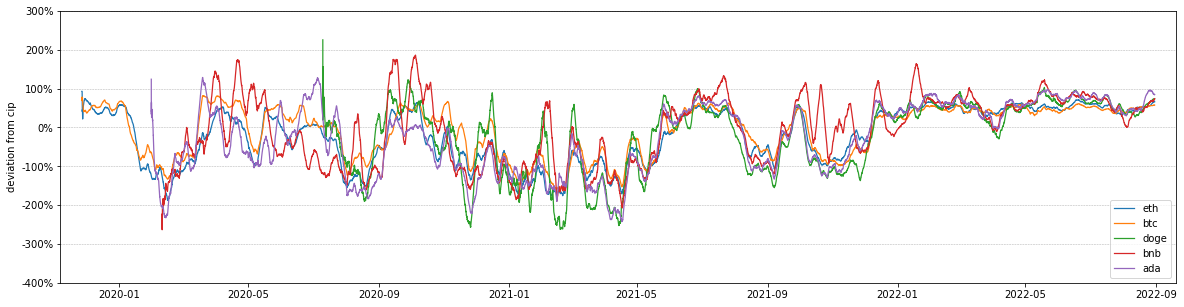

In [95]:
#plotting the cip over time
sns.color_palette()

panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize =(20,5))

for i in range (0,len(currencies)):
    ax.plot(panel_all[i]['timestamp'], panel_all[i]['cip'].rolling(24*7, min_periods=1).mean(), linewidth=1.25)

ax.set_ylim(-4, 3)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


left, right = plt.xlim()
ax.set_xlim(left+30, right-30)

ax.legend(['eth', 'btc', 'doge', 'bnb', 'ada'], loc='lower right')
ax.set_ylabel('deviation from cip')
ax.grid(axis='y', linestyle='--', linewidth=.5)

plt.savefig('figures/figure_2_all_deviations_ma7.png')

plt.show()

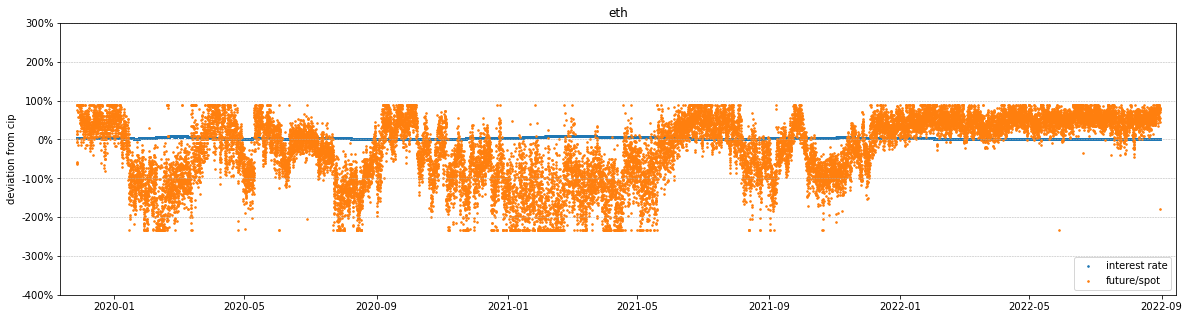

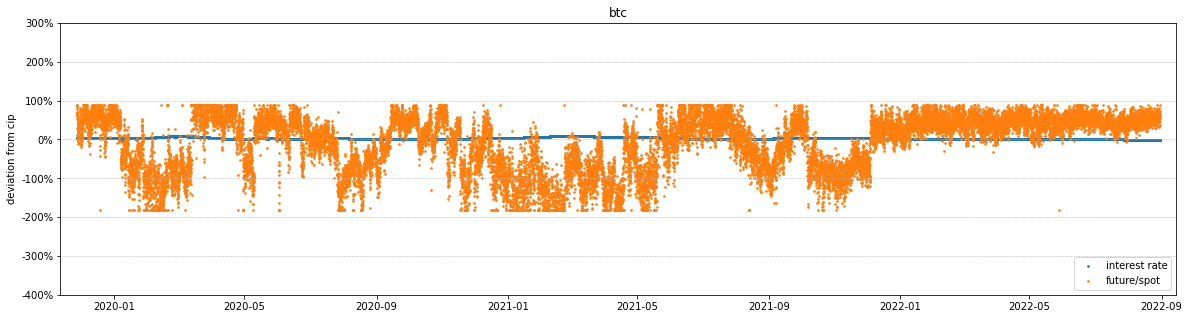

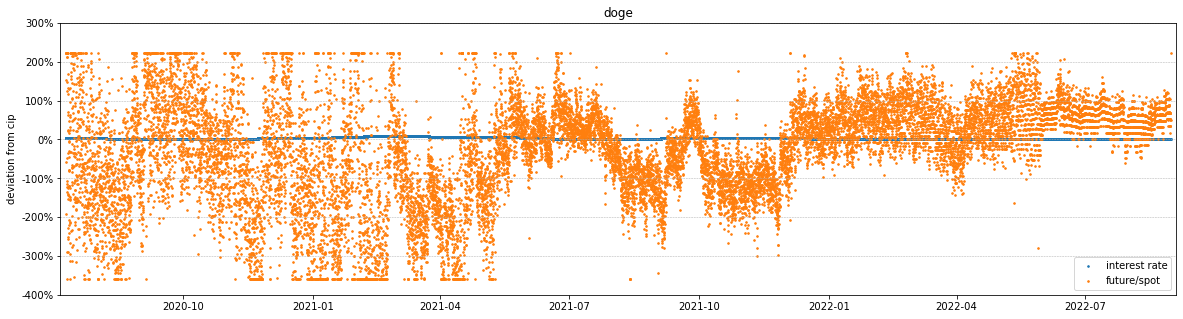

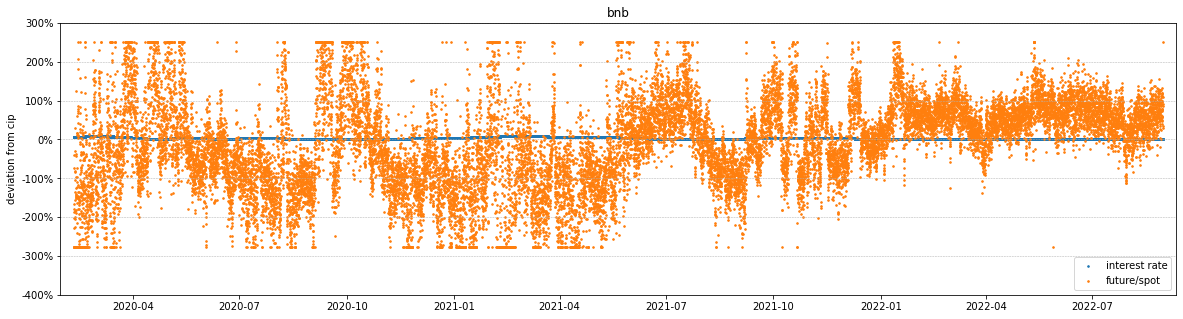

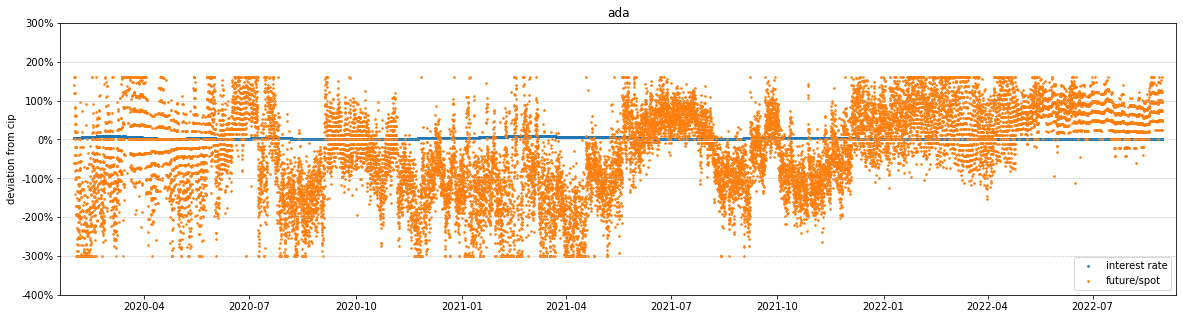

In [96]:
for i in range (0,len(currencies)):
    #plotting the cip over time
    sns.color_palette()
    panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)

    fig, ax = plt.subplots(figsize =(20,5))

    ax.scatter(panel_all[i]['timestamp'].iloc[0:], panel_all[i]['yt'].iloc[0:], s=2.5)
    ax.scatter(panel_all[i]['timestamp'].iloc[0:], panel_all[i]['pt'].iloc[0:], s=2.5)
    
    ax.set_ylim(-4, 3)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
    left, right = plt.xlim()
    ax.set_xlim(left+35, right-35)

    ax.legend(['interest rate', 'future/spot'], loc='lower right')
    ax.set_ylabel('deviation from cip')
    
    ax.grid(axis='y', linestyle='--', linewidth=.5)

    plt.title(f'{currencies[i]}')
    
    plt.savefig(f'figures/figure_3_deviation_{currencies[i]}.png')
    plt.show()

In [97]:
df_corr = panel_all[0][['epoch', 'cip', 'spot']]
df_corr = df_corr.rename(columns={'cip': 'cip_eth', 'spot': 'spot_eth'})

df_corr = pd.merge(df_corr,
                     panel_all[1][['epoch', 'cip', 'spot']],
                     on='epoch', 
                     how='left')
df_corr = df_corr.rename(columns={'cip': 'cip_btc', 'spot': 'spot_btc'})

df_corr = pd.merge(df_corr,
                     panel_all[2][['epoch', 'cip', 'spot']],
                     on='epoch', 
                     how='left')
df_corr = df_corr.rename(columns={'cip': 'cip_doge', 'spot': 'spot_doge'})

df_corr = pd.merge(df_corr,
                     panel_all[3][['epoch', 'cip', 'spot']],
                     on='epoch', 
                     how='left')
df_corr = df_corr.rename(columns={'cip': 'cip_bnb', 'spot': 'spot_bnb'})

df_corr = pd.merge(df_corr,
                     panel_all[4][['epoch', 'cip', 'spot']],
                     on='epoch', 
                     how='left')
df_corr = df_corr.rename(columns={'cip': 'cip_ada', 'spot': 'spot_ada'})
   

df_corr = df_corr.drop(['epoch'], axis=1)

In [98]:
df_corr = df_corr[['cip_eth', 'cip_btc', 'cip_doge', 'cip_bnb', 'cip_ada', 'spot_eth', 'spot_btc', 'spot_doge', 'spot_bnb', 'spot_ada']]

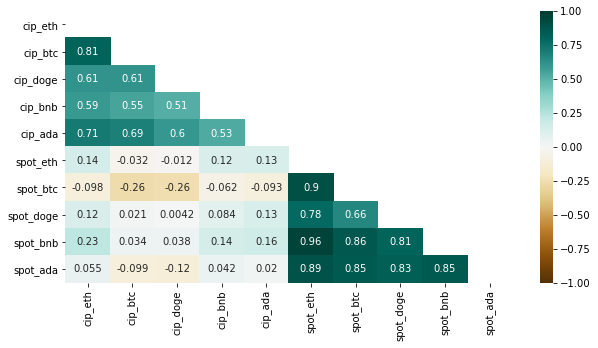

In [100]:
plt.figure(figsize=(10, 5))

mask = np.triu(np.ones_like(df_corr.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.savefig(f'figures/figure_6_correlation.png')

plt.show()

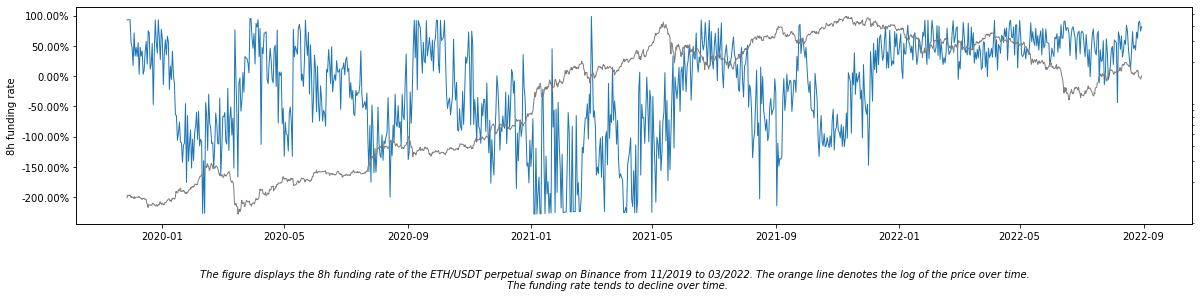

In [101]:
#take a look at the funding rate over time
i = 0

fig, ax = plt.subplots(figsize =(20,4))

ax.plot(panel_all[i]['timestamp'].iloc[0::24], panel_all[i]['cip'].iloc[0::24], linewidth=1)
secax = ax.twinx()
secax.plot(panel_all[i]['timestamp'].iloc[0::12], panel_all[i]['spot'].iloc[0::12], color='grey', linewidth=1)
secax.set_yscale('log')
secax.set_yticks([])

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

ax.set_ylabel('8h funding rate')

r = np.corrcoef(panel_all[0]['cip'], panel_all[0]['spot'])

txt = 'The figure displays the 8h funding rate of the ETH/USDT perpetual swap on Binance from 11/2019 to 03/2022. The orange line denotes the log of the price over time. \n The funding rate tends to decline over time.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()

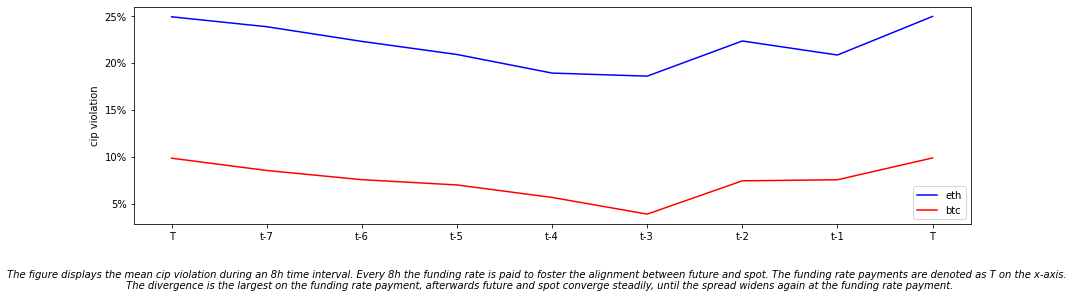

In [102]:
fig, ax = plt.subplots(figsize =(15,4))
col = ['b', 'r']


for i in range(0,2):
    temp = []
    for j in range(1,10): 
        temp.append(abs(panel_all[i]['cip'].iloc[j::8].mean()))
    
    plt.plot(temp, c=col[i], label=currencies[i])

ax.legend(loc='lower right')
ax.set_ylabel('cip violation')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.xticks(np.arange(9), labels = ['T', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'T'])

txt = f'The figure displays the mean cip violation during an 8h time interval. Every 8h the funding rate is paid to foster the alignment between future and spot. The funding rate payments are denoted as T on the x-axis. \n The divergence is the largest on the funding rate payment, afterwards future and spot converge steadily, until the spread widens again at the funding rate payment.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()



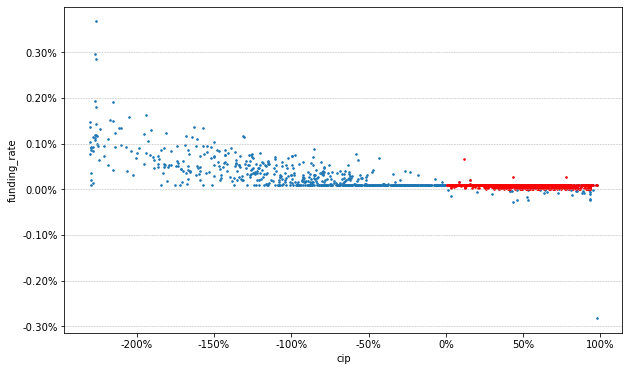

In [103]:
fig, ax = plt.subplots(figsize =(10,6))

ax.scatter(panel_all[0]['cip'][1::8], panel_all[0]['funding_rate'][1::8], s=2.5)
ax.scatter(panel_all[0][(panel_all[0]['cip'] > 0) & (panel_all[0]['funding_rate'] > 0)]['cip'], panel_all[0][(panel_all[0]['cip'] > 0) & (panel_all[0]['funding_rate'] > 0)]['funding_rate'], s=2.5, color='r')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax.set_ylabel('funding_rate')

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel('cip')

ax.grid(axis='y', linestyle='--', linewidth=.5)

plt.show()